In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
#from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import seasonal_decompose
import statistics
import math
import time

# Function Definitions

In [2]:
def editor1(csvPath='exportforuconn.csv', exportname="Cleaned_Data.csv", server_name=None):
    '''
    This file will take the data from LM, import it into a pandas dataframe, and create a new file (also a csv)
    that has a separate row for each timestamp, and in each row has data on the average CPU usage, average disk usage,
    average number of processes being used accross servers, and the total number of servers turned on.
    This is then turned into a new csv file.
    '''

    df = pd.read_csv(csvPath)
    df = df.fillna(0)
    # the sponsors said that if a value in the dataset is empty, that does have meaning,
    # otherwise i would consider ignoring the empty values instead of filling them in as zeros

    #print(df.iloc[1]['Disk_Avg'])
    
    
    # SINGLE SERVER FUNCTIONALITY FOR SCHEDULING!!!
    if server_name:
        df = df[df["host"] == server_name]
    # if there is an inidvidual server asked for, we filter dataset such that only this server's data exists.
    


    timestamps = {}
    iternum = 0
    start = time.time()

    for index, row in df.iterrows():
        if row["_time"] in timestamps:
            timestamps[row["_time"]][0].append(row["CPU_95th_Perc"])
            #timestamps[row["_time"]][1].append(row["process_count"])
            #timestamps[row["_time"]][2].append(row["Disk_Avg"])
            #timestamps[row["_time"]][3] += 1
        else:
            #timestamps[row["_time"]] = [[row["CPU_95th_Perc"]],[row["process_count"]],[row["Disk_Avg"]],1]
            timestamps[row["_time"]] = [[row["CPU_95th_Perc"]]]

        iternum +=1
        if (iternum % 5000) == 0:
            print("iter:", iternum, " time elapsed:", time.time()-start)
            #if iternum == 50000:
            #    break

    # we have one dictionary. The key is a timestamp (str), the value is XXXX a list of 3 lists and an int XXXX     now is a list of 1 list
    # the first of these lists contains all of the CPU_95 data, the second contiains all of the proccess count data,
    # the thrid contains all of the disk_avg data, the in represents the number of servers turned on at that given timestamp.
    # All of these are for a given timestamp.


    headerList = ["Timestamp", "Avg_CPU_95", "Avg_Proc_Count", "Avg_Disk_Avg", "Num_Servers"]

    # for each timestamp, find the mean for each collected stast, keep num_servers the same
    TStamp = []
    Avg_CPU_95 = []
    #Avg_Proc_Count = []
    #Avg_Disk_Avg = []
    #Num_Servers = []



    print()
    #print("timestamps: ", timestamps.items())
    #print("timestamps[0]: ", timestamps[0])
    #print("timestamps[1]: ", timestamps[1])
    #print("timestamps[2]: ", timestamps[2])
    #print("timestamps[3]: ", timestamps[3])

    # v = [[],[],[],int]
    start2 = time.time()
    i = 0
    for t, v in timestamps.items():
        TStamp.append(t[0:16])
        Avg_CPU_95.append(np.mean(v[0]))
        #Avg_Proc_Count.append(np.mean(v[1]))
        #Avg_Disk_Avg.append(np.mean(v[2]))
        #Num_Servers.append(v[3])

        i +=1
        if (i % 500) == 0:
            print("iter:", i, " time elapsed:", time.time()-start2)



    df2 = pd.DataFrame(
        {'Timestamp' : TStamp,
        'Avg_CPU_95' : Avg_CPU_95,
        #'Avg_Proc_Count' : Avg_Proc_Count,
        #'Avg_Disk_Avg' : Avg_Disk_Avg,
        #'Num_Servers' : Num_Servers,
        })


    df2.to_csv(exportname, mode='w', index=False)


In [3]:
def editor2(csvPath="flipflap.csv", exportname="Cleaned_Data.csv"):
    '''
    !!!THIS FUNCTION IS USELESS FOR THIS MODEL, SIMPLY MAKES CSV MORE READABLE FOR HUMANS IF YOU WANT!!!  it is not called in this file.
    
    This file takes the already created aggregated csv file and adds the following new features to it:
    total_num_processes
    day_of_week
    date
    hour
    '''

    df = pd.read_csv(csvPath)

    sun = {"24", "01", "08", "15"}
    mon = {"18", "25", "02", "09", "16"}
    tues = {"19", "26", "03", "10",}
    wed = {"20", "27", "04", "11"}
    thurs = {"21", "28", "05", "12"}
    fri = {"22", "29", "06", "13"}
    sat = {"23", "30", "07", "14"}


    df["Total_Processes"] = ''
    df["Hour"] = ''
    df["Date"] = ''
    df["Day_of_Week"] = ''



    start = time.time()

    for i in range(df.shape[0]):
        tot_proc = df["Avg_Proc_Count"][i] * df["Num_Servers"][i]
        df.loc[i, "Total_Processes"] = tot_proc

        hour = df["Timestamp"][i][11:13]
        df.loc[i, "Hour"] = hour

        date = df["Timestamp"][i][8:10]
        df.loc[i, "Date"] = date

        if date in mon:
            df.loc[i, "Day_of_Week"] = "mon"
        elif date in sun:
            df.loc[i, "Day_of_Week"] = "sun"
        elif date in tues:
            df.loc[i, "Day_of_Week"] = "tues"
        elif date in wed:
            df.loc[i, "Day_of_Week"] = "wed"
        elif date in thurs:
            df.loc[i, "Day_of_Week"] = "thurs"
        elif date in fri:
            df.loc[i, "Day_of_Week"] = "fri"
        elif date in sat:
            df.loc[i, "Day_of_Week"] = "sat"
        else:       #date = 17
            if df["Timestamp"][i][5:7] == "09":
                df.loc[i, "Day_of_Week"] = "sun"
            else:
                df.loc[i, "Day_of_Week"] = "tues"


        if i%500 == 0:
            print("row number: ", i, "time elapsed: ", time.time()-start)



    df.to_csv(exportname, index=False, mode='w')



In [4]:
def half_hour_agg(csvPath="Cleaned_Data.csv", exportname="by_half_hour.csv"):

    df = pd.read_csv(csvPath)

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    df['Rounded_Timestamp'] = df['Timestamp'].dt.round('30min')

    agg_df = df.groupby('Rounded_Timestamp').agg({
        'Avg_CPU_95': 'mean',
        #'Avg_Proc_Count': 'mean',
        #'Avg_Disk_Avg': 'mean',
        #'Num_Servers': 'mean',
        #'Total_Processes': 'mean',
        #'Hour': 'first',
        #'Date': 'first',
        #'Day_of_Week': 'first'
        }).reset_index()

    agg_df = agg_df.rename(columns={'Rounded_Timestamp': 'Timestamp'})


    agg_df.to_csv(exportname, index=False, mode='w')

In [5]:
def aggregate_data(filepath, time_period='30min', exportname="LSTM_by_time_period.csv"):
    # This function aggregates data (can be either file) based on time period chosen by user
    
    df = pd.read_csv(filepath)

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    df['Rounded_Timestamp'] = df['Timestamp'].dt.round(time_period)

    agg_df = df.groupby('Rounded_Timestamp').agg({
        'Avg_CPU_95': 'mean',
        #'Avg_Proc_Count': 'mean',
        #'Avg_Disk_Avg': 'mean',
        #'Num_Servers': 'mean',
        #'Total_Processes': 'mean',
        #'Hour': 'first',
        #'Date': 'first',
        #'Day_of_Week': 'first'
        }).reset_index()

    agg_df = agg_df.rename(columns={'Rounded_Timestamp': 'Timestamp'})

    agg_df.to_csv(exportname, index=False, mode='w')

In [6]:
def prepare_data(data, sequence_length=12, train_test_split=.75):
   
    # data is a list    
    data_normalized = scaler.fit_transform(np.array(data).reshape(-1, 1)).flatten()
    

    # sequence_length=12 means use past 12 hours of data to predict the next hour
    # data_X is a list of subsequences of length sequence_length.
    # data_y has the real target value that comes immedietly after the corresponding subsequence in data_X
    # LSTM model is trying to predict the ith value of data_y based on the ith subsequence in data_X
    # doing this is what allows the model to find patterns in the data
    data_X, data_y = [], []
    for i in range(len(data_normalized) - sequence_length):
        data_X.append(data_normalized[i:i+sequence_length])
        data_y.append(data_normalized[i+sequence_length])


    # convert python lists to numpy ndarrays
    data_X = np.array(data_X)
    data_y = np.array(data_y)

    # convert ndarrays to tensors, needed for pytorch
    X = torch.tensor(data_X, dtype=torch.float32)
    y = torch.tensor(data_y, dtype=torch.float32)

    # split data into train and test
    split = math.floor(len(X) * train_test_split)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # reshape data for LSTM model
    X_train = X_train.view(-1, sequence_length, 1)
    X_test = X_test.view(-1, sequence_length, 1)

    # prepare output
    train_loader = (X_train, y_train)
    test_loader = (X_test, y_test)
    return train_loader, test_loader, split, sequence_length

In [7]:
# Define LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size  # I found the optimal hidden layer size to be 50 (tested 50, 75, 100)
        # defining the different layers of the LSTM model
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        # specifies how each pass through the model works
        # Pytorch does this for me when the model is training, which is why it is never called explicitly in the code.
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [8]:
def Training(model, optimizer, train_loader, num_epochs=20):
    start = time.time()
    loss_function = nn.MSELoss()
    # MSE loss makes the most sense imo

    for i in range(num_epochs):
        for seq, labels in zip(train_loader[0], train_loader[1]):
            optimizer.zero_grad()         # reset gradient from pervious iterations

            # reset hidden layer
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)           # performs prediction on seq using the model
            single_loss = loss_function(y_pred, labels)     # calculate mse
            single_loss.backward()        # backpropogation
            optimizer.step()              # update optimizer weights

        if i%3 == 0:
            print("epoch: {:3} loss: {:10.8f} time elapsed: {}".format(
                i, single_loss.item(), time.time()-start))

    return model

In [9]:
def Testing(model, test_loader, split, sequence_length, timestamps, name):
    model.eval()
    y_pred = []
    for seq in test_loader[0]:  # Iter over the test loader
        with torch.no_grad():
            # reset the hidden layer for each seq, then append predicted value to y_pred
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred.append(model(seq).item())


    # transform y_pred to be similar to y_test
    y_pred_trans = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
    y_test = test_loader[1]


    # calculate and return the RMSE value, then plot the predicted and real values for the testing data
    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_trans)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)

    plt.figure(figsize=(15, 6))
    plt.plot(timestamps[split+sequence_length:], y_pred_trans, label='Predicted')
    plt.plot(timestamps[split+sequence_length:], scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(), label='Real')
    plt.xlabel('Timestamp')
    plt.ylabel('CPU Usage')
    plt.title('Real vs Predicted CPU Usage')
    plt.legend()
    plt.savefig(name)
    plt.show()

    return rmse, y_pred

# Model Train/Test

In [10]:
df = pd.read_csv("by_half_hour.csv",  parse_dates=True)
timestamp_list = df["Timestamp"].tolist()
timestamps = pd.to_datetime(timestamp_list)
#cpu_data = df["Total_CPU_95"].tolist()
cpu_data = df["Avg_CPU_95"].tolist()

# MinMaxScaler scales the data so that it is all within the range of (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))

c:\Users\nicho\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00521301 time elapsed: 3.086362361907959
epoch:   3 loss: 0.00197196 time elapsed: 12.484076499938965
epoch:   6 loss: 0.00084636 time elapsed: 22.083581924438477
epoch:   9 loss: 0.00034713 time elapsed: 31.67158055305481
epoch:  12 loss: 0.00013818 time elapsed: 41.32614731788635
epoch:  15 loss: 0.00005140 time elapsed: 51.082590103149414
epoch:  18 loss: 0.00001481 time elapsed: 60.84670114517212
epoch:  21 loss: 0.00000207 time elapsed: 71.05243873596191
epoch:  24 loss: 0.00000005 time elapsed: 80.74026226997375
RMSE:  0.4323913437304131


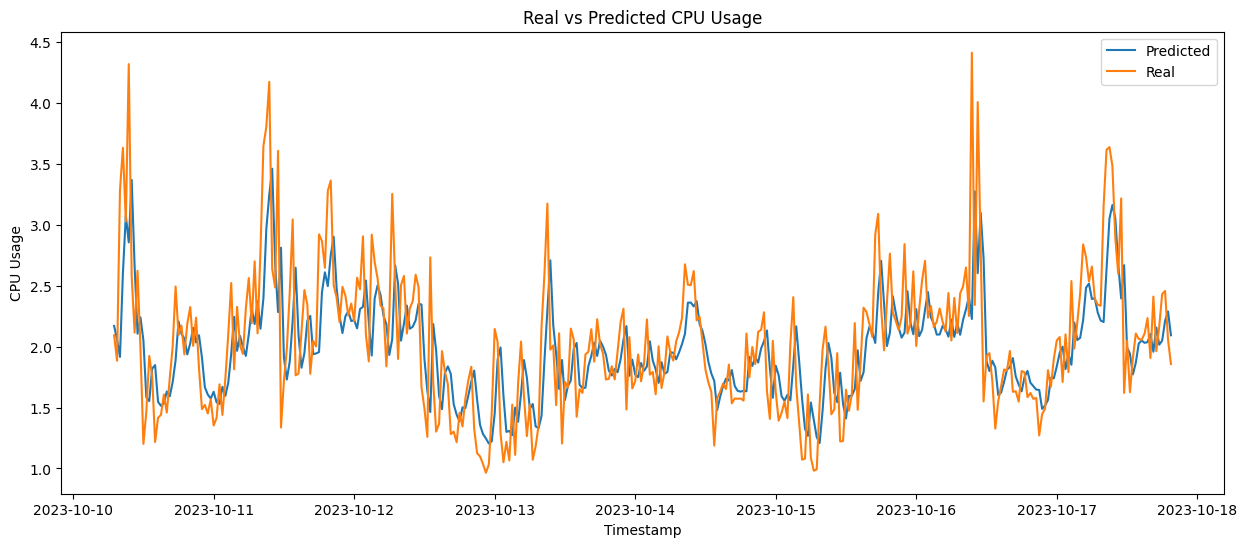

rmse:  0.4323913437304131


In [11]:
train, test, split, sequence_length = prepare_data(cpu_data, sequence_length=12, train_test_split=.75)
model = LSTMModel(hidden_layer_size=50)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

result = Training(model, optimizer, train, num_epochs=25)
rmse, Y_Pred = Testing(result, test, split, sequence_length, timestamps, "Real_Pred_Graph")
print("rmse: ", rmse)

In [12]:
dataRange =  max(cpu_data)-min(cpu_data)
print("Range of Data:  " , dataRange)

Range of Data:   4.464884636118599


In [13]:
print(.4342289454 / 4.464884636)
print("RMSE / Range:", rmse/dataRange)

0.09725423629064175
RMSE / Range: 0.0968426687293534


# Scheduling v3

In [ ]:
# First I show the modeling for the single server. You do need to use Testing() for this to work because I need Y_Pred,
# but I wouldnt show the model since it is bad for a single server.


In [40]:
editor1("exportforuconn.csv", exportname="LSTM_Filler.csv", server_name="d84433utw1.example.com")
half_hour_agg("LSTM_Filler.csv", exportname="LSTM_Single.csv")

iter: 5000  time elapsed: 0.33719754219055176

iter: 500  time elapsed: 0.00398564338684082
iter: 1000  time elapsed: 0.011986970901489258
iter: 1500  time elapsed: 0.01998758316040039
iter: 2000  time elapsed: 0.027984619140625
iter: 2500  time elapsed: 0.03298234939575195
iter: 3000  time elapsed: 0.03698301315307617
iter: 3500  time elapsed: 0.04109954833984375
iter: 4000  time elapsed: 0.047109127044677734
iter: 4500  time elapsed: 0.05110001564025879
iter: 5000  time elapsed: 0.05610060691833496
iter: 5500  time elapsed: 0.06111264228820801
iter: 6000  time elapsed: 0.06609940528869629
iter: 6500  time elapsed: 0.07110452651977539
iter: 7000  time elapsed: 0.0763254165649414
iter: 7500  time elapsed: 0.08144402503967285
iter: 8000  time elapsed: 0.08632993698120117
iter: 8500  time elapsed: 0.09133696556091309


In [41]:
single_df = pd.read_csv("LSTM_Single.csv", parse_dates=True)
single_ts = pd.to_datetime(single_df["Timestamp"].tolist())
single_cpu = single_df["Avg_CPU_95"].tolist()
scaler = MinMaxScaler(feature_range=(0, 1))

print(single_df.head())

             Timestamp  Avg_CPU_95
0  2023-09-17 11:00:00    0.190000
1  2023-09-17 11:30:00    2.070000
2  2023-09-17 12:00:00    2.848333
3  2023-09-17 12:30:00    0.432000
4  2023-09-17 13:00:00    1.135000


c:\Users\nicho\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00022953 time elapsed: 3.3142166137695312
epoch:   3 loss: 0.00020603 time elapsed: 14.214064359664917
epoch:   6 loss: 0.00018945 time elapsed: 25.13775658607483
epoch:   9 loss: 0.00017661 time elapsed: 35.300983905792236
epoch:  12 loss: 0.00016780 time elapsed: 46.45180034637451
RMSE:  1.4732528455830705


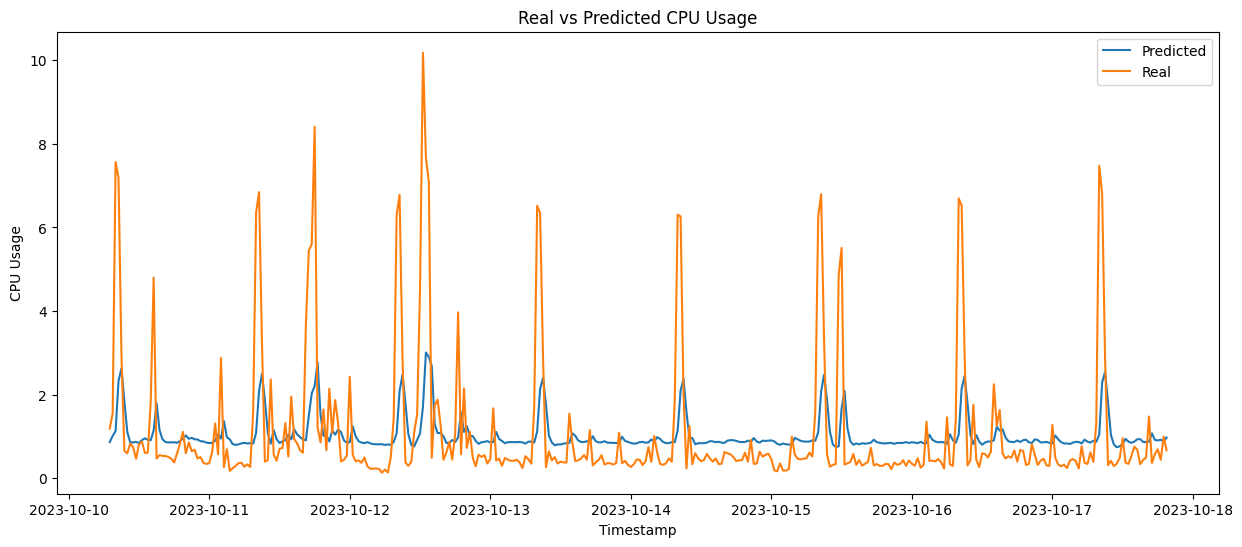

rmse:  1.4732528455830705


In [42]:
s_train, s_test, s_split, s_sequence_length = prepare_data(single_cpu, sequence_length=12, train_test_split=.75)
s_model = LSTMModel(hidden_layer_size=50)
s_optimizer = torch.optim.Adam(s_model.parameters(), lr=.0001)

s_result = Training(s_model, s_optimizer, s_train, num_epochs=15)
rmse, Y_Pred = Testing(s_result, s_test, s_split, s_sequence_length, single_ts, "Single_Server_Graph")
print("rmse: ", rmse)

In [43]:
# SCHEUDLING NOW

mean_predicted = statistics.mean(Y_Pred)
std_predicted = statistics.stdev(Y_Pred)
lower_bound = mean_predicted - std_predicted
upper_bound = mean_predicted + std_predicted

test_single_ts = single_ts[s_split+s_sequence_length:]
# starts at 2023-10-10 07:00
# ends at 2023-10-17 19:30
# index 34 is the start of the next day.
# index -40 is start of th last day, which is incomplete
# we probably want to show a single day from midnight to midnight.
# so we get the last full day, the 16th, which is indices [-88 : -40] (not including -40)
# this is aggregated by half hour

valid_single_ts = test_single_ts[-88:-40]
corresponding_Y_Pred = Y_Pred[-88:-40]

server_states = []
state = "Off"
for cpu in corresponding_Y_Pred:
    if cpu < lower_bound:
        state = "Off"
    elif cpu > upper_bound:
        state = "On"
    server_states.append(state)

schedule_df = pd.DataFrame(index=valid_single_ts, data={"Server_State": server_states})

#schedule_df = pd.DataFrame(index=valid_single_ts, data={"Predicted_CPU_Usage": corresponding_Y_Pred})
# ^ if you want to see the predicted cpu values at each timestamp instead

In [44]:
schedule_df

,Server_State
2023-10-16 00:00:00,Off
2023-10-16 00:30:00,Off
2023-10-16 01:00:00,Off
2023-10-16 01:30:00,Off
2023-10-16 02:00:00,Off
2023-10-16 02:30:00,Off
2023-10-16 03:00:00,Off
2023-10-16 03:30:00,Off
2023-10-16 04:00:00,Off
2023-10-16 04:30:00,Off


In [45]:
print(mean_predicted)
print(std_predicted)
print(lower_bound)
print(upper_bound)

0.024704680603141613
0.00978601338517553
0.014918667217966083
0.03449069398831714


# Testing on Other Data

In [ ]:
# The new dataset we received from Lockheed
df2 = pd.read_csv('LSTM_by_time_period.csv',  parse_dates=True)
timestamps2_list = df2["Timestamp"].tolist()
timestamps2 = pd.to_datetime(timestamps2_list)
cpu_data2 = df2["Avg_CPU_95"].tolist()

In [ ]:
# we dont want to train the model again on this data, just test on it, hence the split=0
# if split=0, train2 is empty
train2, test2, split2, seq_len2 = prepare_data(cpu_data2, train_test_split=0)

RMSE:  0.4253729048146983


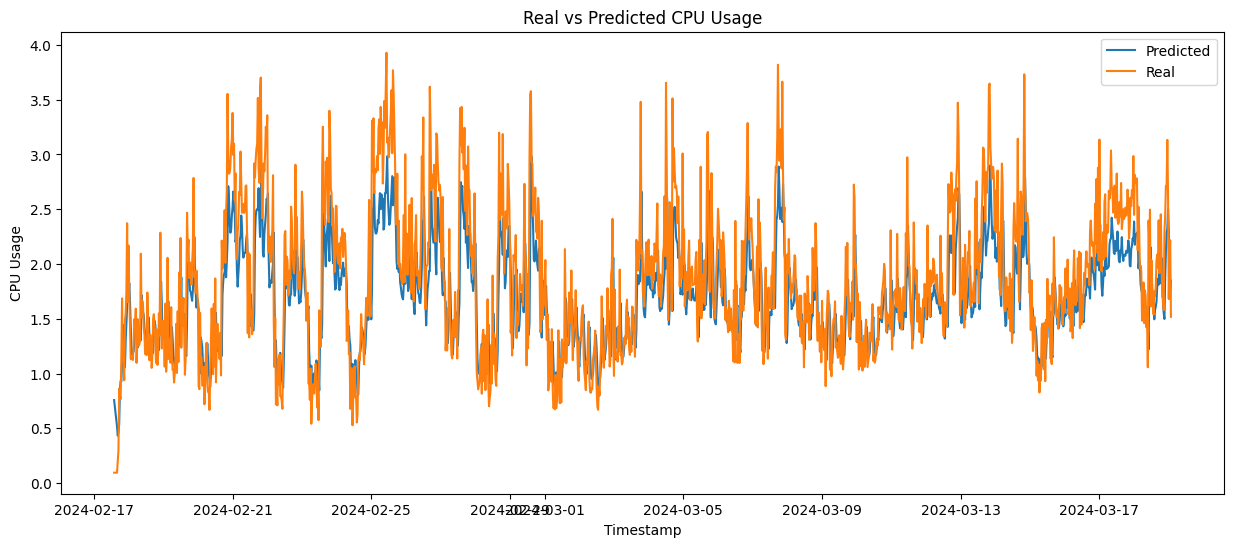

In [ ]:
rmse2, y_pred2 = Testing(result, test2, split2, seq_len2, timestamps2, "Jan-Feb_Graph")

In [ ]:
print(max(cpu_data2)-min(cpu_data2))

3.92908


# Custom Time Window

In [ ]:
def time_window_testing(model, test_loader, timestamps, split=0, sequence_length=0, name="Limited_Time_Graph"):
    #
    # if user wants to only view a subset of the testing results, use this function
    # split and sequence_length should be 0 if not using the train dataset
    # if using the train dataset, they should be their real values.

    timestamps = timestamps[0+split+sequence_length:]


    print("earliest timestamp: ", timestamps[0])
    print("latest timestamp: ", timestamps[-1])
    start_time = input("select start time to view (YYYY-MM-DD HH:SS:00):  ")
    end_time = input("select end time to view (YYYY-MM-DD HH:SS:00):  " )


    try:
        start_time = pd.to_datetime(start_time)
    except ValueError:
        start_time = pd.to_datetime(timestamps[0])

    try:
        end_time = pd.to_datetime(end_time)
    except ValueError:
        end_time = pd.to_datetime(timestamps[-1])


    if start_time < timestamps[0] or start_time > timestamps[-1]:
        start_time=timestamps[0]
    if end_time > timestamps[-1] or end_time < timestamps[0]:
        end_time=timestamps[-1]
    if start_time > end_time:
        temp = start_time
        start_time = end_time
        end_time = temp

    start_timestamp_index = timestamps.get_loc(start_time)
    end_timestamp_index = timestamps.get_loc(end_time)


    # rest is copied from Testing()
    model.eval()
    y_pred = []
    for seq in test_loader[0]:  # Iter over the test loader
        with torch.no_grad():
            # reset the hidden layer for each seq, then append predicted value to y_pred
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred.append(model(seq).item())

    # transform y_pred to be similar to y_test
    y_pred_trans = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
    y_test = test_loader[1]

    print("len y_pred: ", len(y_pred_trans))
    print("len y_test: ",len(y_test))
    print("len timestamps: ",len(timestamps))
    print()
    print("len y_pred: ", len(y_pred_trans[start_timestamp_index:end_timestamp_index]))
    print("len timestamps: ", len(timestamps[start_timestamp_index:end_timestamp_index+1]))



    # timestamps[0+split+sequence_length+start_timestamp_index] corresponds to y_pred_trans[0]

    # calculate and return the RMSE value, then plot the predicted and real values for the testing data
    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_trans)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)

    plt.figure(figsize=(15, 6))
    plt.plot(timestamps[start_timestamp_index:end_timestamp_index], y_pred_trans[start_timestamp_index:end_timestamp_index], label='Predicted')
    plt.plot(timestamps[start_timestamp_index:end_timestamp_index], scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()[start_timestamp_index:end_timestamp_index], label='Real')
    plt.xlabel('Timestamp')
    plt.ylabel('CPU Usage')
    plt.title('Real vs Predicted CPU Usage')
    plt.legend()
    plt.savefig(name)
    plt.show()

    return rmse, y_pred

earliest timestamp:  2024-02-17 14:00:00
latest timestamp:  2024-03-19 01:30:00
len y_pred:  1461
len y_test:  1461
len timestamps:  1461

len y_pred:  1460
len timestamps:  1461
RMSE:  0.42537373693328007


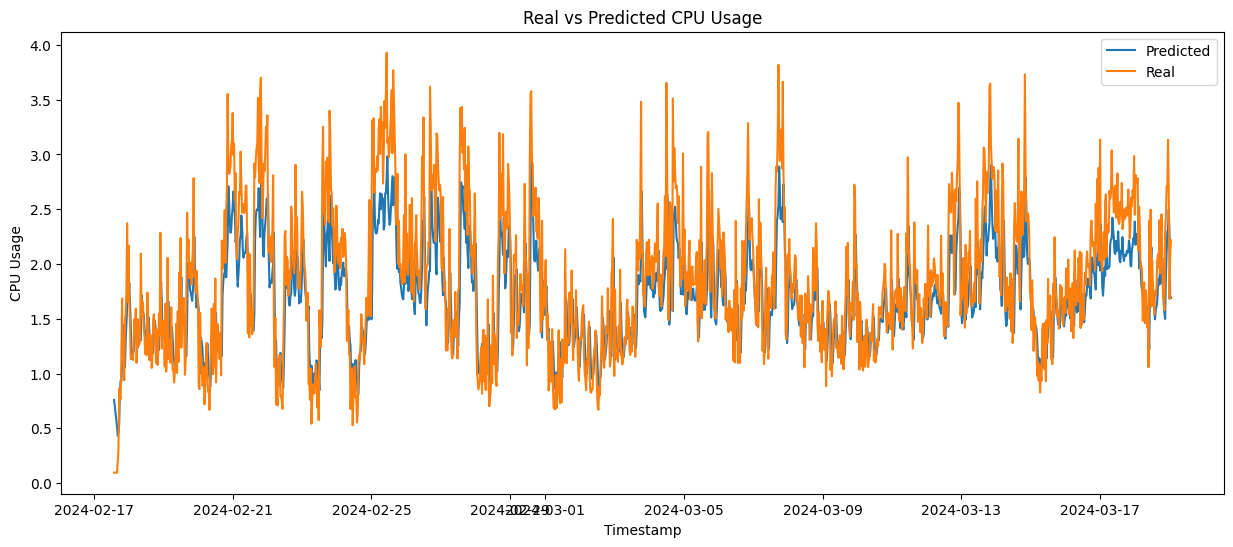

In [ ]:
fil, ler = time_window_testing(result, test2, timestamps2, split2, seq_len2)

earliest timestamp:  2023-10-10 07:00:00
latest timestamp:  2023-10-17 19:30:00
len y_pred:  362
len y_test:  362
len timestamps:  362

len y_pred:  279
len timestamps:  280
RMSE:  0.38211970612293933


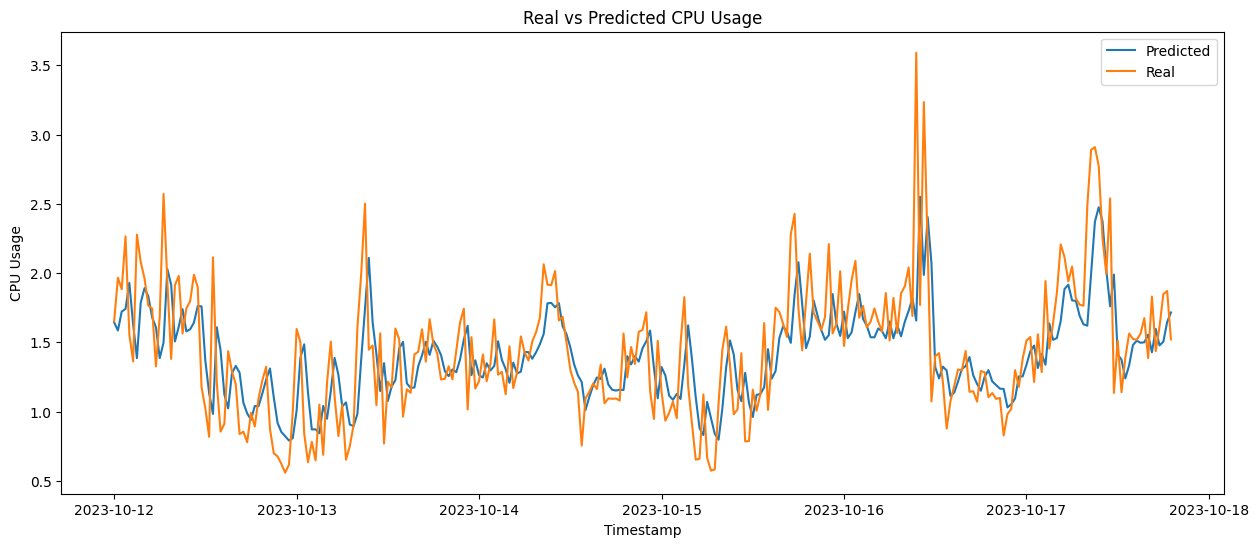

In [ ]:
abra, cadabra = time_window_testing(result, test, timestamps, split, sequence_length)

# Old Scheduling

In [ ]:
def scheduling(timestamps, y_pred, periods=48):

    last_24h_time = timestamps[-periods:]
    last_24h_pred = y_pred[-periods:]
    median_cpu = statistics.median(last_24h_pred)

    #print(last_24h_time)
    #print(last_24h_pred)
    #print(median_cpu)
    #print()

    on_off_df = pd.DataFrame(last_24h_time, columns=['Time'])
    on_off_df['Servers'] = False

    for index, row in on_off_df.iterrows():
        if last_24h_pred[index] > median_cpu:
            on_off_df.at[index, 'Servers'] = True

    return on_off_df

In [ ]:
schedule = scheduling(timestamps, Y_Pred)
print(schedule)

                  Time  Servers
0  2023-10-16 20:00:00    False
1  2023-10-16 20:30:00    False
2  2023-10-16 21:00:00    False
3  2023-10-16 21:30:00    False
4  2023-10-16 22:00:00    False
5  2023-10-16 22:30:00    False
6  2023-10-16 23:00:00    False
7  2023-10-16 23:30:00    False
8  2023-10-17 00:00:00    False
9  2023-10-17 00:30:00    False
10 2023-10-17 01:00:00    False
11 2023-10-17 01:30:00    False
12 2023-10-17 02:00:00    False
13 2023-10-17 02:30:00    False
14 2023-10-17 03:00:00     True
15 2023-10-17 03:30:00     True
16 2023-10-17 04:00:00     True
17 2023-10-17 04:30:00     True
18 2023-10-17 05:00:00     True
19 2023-10-17 05:30:00     True
20 2023-10-17 06:00:00     True
21 2023-10-17 06:30:00     True
22 2023-10-17 07:00:00     True
23 2023-10-17 07:30:00     True
24 2023-10-17 08:00:00     True
25 2023-10-17 08:30:00     True
26 2023-10-17 09:00:00     True
27 2023-10-17 09:30:00     True
28 2023-10-17 10:00:00     True
29 2023-10-17 10:30:00     True
30 2023-

# Seasonality

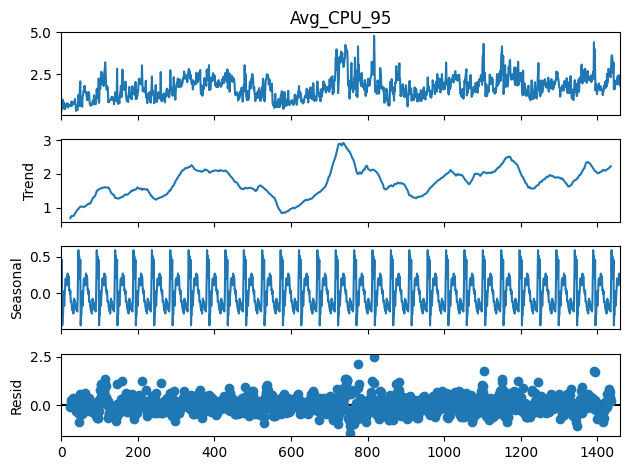

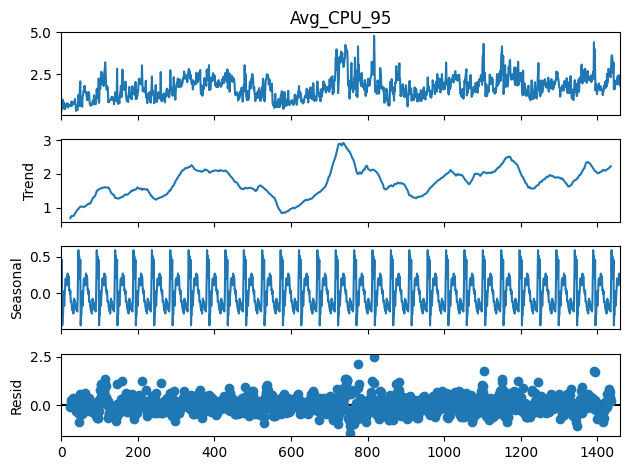

In [ ]:
# Basic method of seeing trend and seasonality of data. period=48 because there are
# 48 observations per period, period being each day and there being 48 half-hour intervals each day
seasonal_res = seasonal_decompose(df['Avg_CPU_95'], period=48)
seasonal_res.plot()